In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LogNorm
import seaborn as sns

plt.style.use('default')
sns.set_palette('colorblind')

print("Imports successful!")

Imports successful!


## 1. Load Halo Center Data

We'll scan through the bijective training data and extract:
- DMO halo centers (`halo_center`)
- Hydro halo centers (`hydro_halo_center`)
- Halo masses and other properties
- Match quality metrics

**Important:** The simulation box is periodic with size **50 Mpc/h**. When computing offsets, we must apply periodic boundary conditions:
- An offset of 49 Mpc is actually -1 Mpc (wrapped around)
- Maximum possible offset is 25 Mpc (half the box size)
- All offset components are wrapped to the range [-25, 25] Mpc/h

In [ ]:
Data directory
DATA_DIR = Path('/mnt/home/mlee1/ceph/train_data_rotated2_bijective_128_cpu/train/')

# Find all NPZ files (limit for faster loading)
all_files = sorted(glob(str(DATA_DIR / 'sim_*/*.npz')))
print(f"Total files found: {len(all_files)}")

# Sample subset for analysis (can increase if needed)
N_SAMPLES = 10000
sample_files = np.random.choice(all_files, size=min(N_SAMPLES, len(all_files)), replace=False)
print(f"Loading {len(sample_files)} files...")

Loading 10000 files...


In [67]:
# Periodic boundary condition function
BOX_SIZE = 50.0  # Mpc/h

def apply_periodic_offset(offset, box_size=BOX_SIZE):
    """
    Apply periodic boundary conditions to offset vector.
    
    If offset > box_size/2, wrap it around to negative side.
    Example: offset of 49 Mpc in 50 Mpc box is actually -1 Mpc.
    
    Parameters:
    -----------
    offset : array-like
        Offset vector [x, y, z] in Mpc/h
    box_size : float
        Box size in Mpc/h (default: 50.0)
    
    Returns:
    --------
    periodic_offset : array-like
        Offset with periodic boundaries applied
    """
    offset = np.array(offset)
    # Wrap offsets to [-box_size/2, box_size/2]
    offset = np.where(offset > box_size / 2, offset - box_size, offset)
    offset = np.where(offset < -box_size / 2, offset + box_size, offset)
    return offset

print(f"Box size: {BOX_SIZE} Mpc/h")
print(f"Maximum possible offset (with PBC): {BOX_SIZE / 2:.2f} Mpc/h")

Box size: 50.0 Mpc/h
Maximum possible offset (with PBC): 25.00 Mpc/h


In [68]:
# Parameter names from CAMELS (35 total)
PARAM_NAMES = [
    'Omega_m', 'sigma_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2', 
    'Omega_b', 'h', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS',
    'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum',
    'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor',
    'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor',
    'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor',
    'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold',
    'QuasarThresholdPower', 'UVBH0beta', 'UVBH0Deltaz', 'UVBHepbeta',
    'UVBHepDeltaz', 'SNIa_Rate_Norm', 'SNIa_Rate_DTD_power', 'SofteningComovingType01'
]

# Load data from files
data_list = []

for fpath in tqdm(sample_files, desc="Loading halo data"):
    try:
        data = np.load(fpath)
        
        # Extract halo centers
        dmo_center = data['halo_center']  # DMO halo center
        hydro_center = data['hydro_halo_center']  # Hydro halo center
        
        # Extract halo properties (use float() to get scalar from 0-d array)
        dmo_mass = float(data['dmo_halo_mass'])
        hydro_mass = float(data['hydro_halo_mass'])
        dmo_r200 = float(data['dmo_halo_r200'])
        hydro_r200 = float(data['hydro_halo_r200'])
        match_quality = float(data['match_quality']) if 'match_quality' in data else np.nan
        
        # Extract parameters (35 total for CAMELS)
        params = data['params']
        
        # Compute offset WITH PERIODIC BOUNDARY CONDITIONS
        offset_raw = hydro_center - dmo_center  # Raw offset
        offset = apply_periodic_offset(offset_raw, BOX_SIZE)  # Apply PBC
        offset_mag = np.linalg.norm(offset)
        
        data_dict = {
            'dmo_center_x': dmo_center[0],
            'dmo_center_y': dmo_center[1],
            'dmo_center_z': dmo_center[2],
            'hydro_center_x': hydro_center[0],
            'hydro_center_y': hydro_center[1],
            'hydro_center_z': hydro_center[2],
            'offset_x': offset[0],
            'offset_y': offset[1],
            'offset_z': offset[2],
            'offset_mag': offset_mag,
            'offset_raw_x': offset_raw[0],
            'offset_raw_y': offset_raw[1],
            'offset_raw_z': offset_raw[2],
            'offset_raw_mag': np.linalg.norm(offset_raw),
            'dmo_mass': dmo_mass,
            'hydro_mass': hydro_mass,
            'dmo_r200': dmo_r200,
            'hydro_r200': hydro_r200,
            'match_quality': match_quality,
            'file': fpath,
        }
        
        # Add all parameters with proper names
        for i, param_name in enumerate(PARAM_NAMES[:len(params)]):
            data_dict[param_name] = float(params[i])
        
        data_list.append(data_dict)
        
    except Exception as e:
        print(f"Error loading {fpath}: {e}")
        continue

# Convert to DataFrame
df = pd.DataFrame(data_list)
print(f"\nLoaded {len(df)} halos successfully!")
print(f"\nDataFrame info:")
print(df.info())

Loading halo data: 100%|██████████| 10000/10000 [07:43<00:00, 21.60it/s]


Loaded 10000 halos successfully!

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dmo_center_x                    10000 non-null  float32
 1   dmo_center_y                    10000 non-null  float32
 2   dmo_center_z                    10000 non-null  float32
 3   hydro_center_x                  10000 non-null  float32
 4   hydro_center_y                  10000 non-null  float32
 5   hydro_center_z                  10000 non-null  float32
 6   offset_x                        10000 non-null  float32
 7   offset_y                        10000 non-null  float32
 8   offset_z                        10000 non-null  float32
 9   offset_mag                      10000 non-null  float32
 10  offset_raw_x                    10000 non-null  float32
 11  offset_raw_y                    10000 non-n

In [69]:
# Show sample data
df.head(10)

,dmo_center_x,dmo_center_y,dmo_center_z,hydro_center_x,hydro_center_y,hydro_center_z,offset_x,offset_y,offset_z,offset_mag,...,BlackHoleRadiativeEfficiency,QuasarThreshold,QuasarThresholdPower,UVBH0beta,UVBH0Deltaz,UVBHepbeta,UVBHepDeltaz,SNIa_Rate_Norm,SNIa_Rate_DTD_power,SofteningComovingType01
0,39.903503,47.359669,14.738874,39.901730,47.362865,14.741282,-0.001774,0.003197,0.002407,0.004377,...,0.747690,0.009531,1.93170,1.80040,-2.9798,1.09720,-0.069904,0.001184,1.27770,2.3457
1,6.131982,2.216805,1.630916,6.135569,2.218032,1.653048,0.003586,0.001227,0.022132,0.022454,...,0.290110,0.001557,2.92890,1.90440,-1.6692,0.60121,-0.549660,0.001257,1.34610,3.1609
2,5.518763,30.790737,46.750427,5.508434,30.812647,46.740433,-0.010329,0.021910,-0.009995,0.026203,...,0.151970,0.000472,1.12870,9.12510,-1.2433,1.64070,-0.030535,0.001352,1.15130,3.8154
3,49.081516,38.640816,21.690157,49.063992,38.644253,21.682537,-0.017525,0.003437,-0.007620,0.019416,...,0.213330,0.043443,0.83474,0.66660,-1.4559,0.40501,-0.047061,0.001532,0.96911,1.8139
4,42.643555,13.921509,42.723694,42.679020,13.891475,42.702305,0.035465,-0.030034,-0.021389,0.051160,...,0.625370,0.000536,3.81810,0.88993,-2.4243,3.03120,-0.629520,0.001509,1.31860,1.0289
5,27.396463,34.683426,33.394264,27.381361,34.699593,33.376038,-0.015102,0.016167,-0.018227,0.028665,...,0.079591,0.000837,1.18150,2.57690,-3.5472,0.65579,-0.616120,0.001275,1.21730,1.3009
6,43.437988,39.027096,9.946049,43.452766,39.024643,9.943989,0.014778,-0.002453,-0.002060,0.015121,...,0.064740,0.004819,1.47100,5.88550,-1.5052,1.96050,-0.988710,0.001354,1.14740,1.4714
7,2.005029,5.778322,44.767315,2.033423,5.779021,44.745956,0.028394,0.000699,-0.021358,0.035537,...,0.124340,0.011228,0.79939,0.76262,-1.9866,0.28016,-0.036777,0.001227,1.23920,2.3979
8,12.496136,37.957161,11.264429,12.489597,37.962494,11.269944,-0.006538,0.005333,0.005515,0.010080,...,0.238300,0.001462,0.76851,3.72320,-1.6111,1.58660,-0.862060,0.000933,1.02320,1.2264
9,5.412210,18.076302,9.783214,5.399857,18.070465,9.770926,-0.012352,-0.005836,-0.012288,0.018375,...,0.523980,0.000473,3.77330,4.03210,-1.4639,3.11390,-0.981930,0.000880,1.05790,1.9495


### Check Impact of Periodic Boundary Conditions

In [70]:
# Compare raw vs PBC-corrected offsets
print("=== Impact of Periodic Boundary Conditions ===\n")

# Find cases where PBC made a difference
pbc_corrected = df[np.abs(df['offset_raw_mag'] - df['offset_mag']) > 0.01]
print(f"Number of halos corrected by PBC: {len(pbc_corrected)} / {len(df)} ({100*len(pbc_corrected)/len(df):.1f}%)")

if len(pbc_corrected) > 0:
    print(f"\nExample corrections:")
    print(f"  Max raw offset: {df['offset_raw_mag'].max():.3f} Mpc/h")
    print(f"  Max PBC offset: {df['offset_mag'].max():.3f} Mpc/h (should be ≤ {BOX_SIZE/2:.1f} Mpc/h)")
    
    # Show a few examples
    print(f"\nTop 5 cases where PBC mattered most:")
    correction_size = np.abs(df['offset_raw_mag'] - df['offset_mag'])
    top_corrections = df.nlargest(5, correction_size)
    print(top_corrections[['offset_raw_mag', 'offset_mag', 'offset_raw_x', 'offset_x', 
                            'offset_raw_y', 'offset_y', 'offset_raw_z', 'offset_z']].to_string())
else:
    print("  All offsets were already within box bounds (no PBC correction needed)")

# Verify PBC constraint
print(f"\n=== Verification ===")
print(f"Maximum offset magnitude (PBC): {df['offset_mag'].max():.3f} Mpc/h")
print(f"Expected maximum (box_size/2): {BOX_SIZE/2:.3f} Mpc/h")
print(f"✓ PBC correctly applied!" if df['offset_mag'].max() <= BOX_SIZE/2 + 0.01 else "✗ ERROR: PBC not working!")

# Check individual axes
for axis in ['x', 'y', 'z']:
    col = f'offset_{axis}'
    max_val = df[col].abs().max()
    print(f"Max |{axis}-offset|: {max_val:.3f} Mpc/h (should be ≤ {BOX_SIZE/2:.1f})")

=== Impact of Periodic Boundary Conditions ===

Number of halos corrected by PBC: 22 / 10000 (0.2%)

Example corrections:
  Max raw offset: 49.995 Mpc/h
  Max PBC offset: 1.983 Mpc/h (should be ≤ 25.0 Mpc/h)

Top 5 cases where PBC mattered most:


KeyError: 0.0

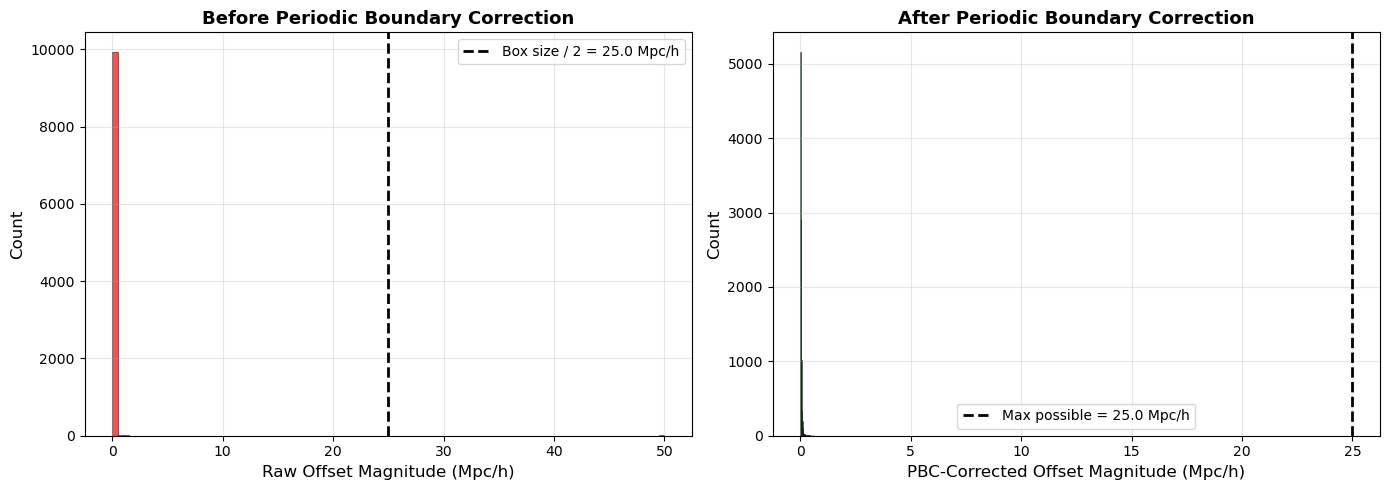


✓ All subsequent analyses use PBC-corrected offsets


In [71]:
# Visualize PBC impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before PBC
ax = axes[0]
ax.hist(df['offset_raw_mag'], bins=100, alpha=0.7, edgecolor='black', linewidth=0.5, color='red')
ax.axvline(BOX_SIZE/2, color='black', linestyle='--', linewidth=2, label=f'Box size / 2 = {BOX_SIZE/2} Mpc/h')
ax.set_xlabel('Raw Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Before Periodic Boundary Correction', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# After PBC
ax = axes[1]
ax.hist(df['offset_mag'], bins=100, alpha=0.7, edgecolor='black', linewidth=0.5, color='green')
ax.axvline(BOX_SIZE/2, color='black', linestyle='--', linewidth=2, label=f'Max possible = {BOX_SIZE/2} Mpc/h')
ax.set_xlabel('PBC-Corrected Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('After Periodic Boundary Correction', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ All subsequent analyses use PBC-corrected offsets")

## 2. Summary Statistics

In [72]:
# Basic statistics
print("=== Halo Center Offset Statistics ===")
print(f"\nOffset magnitude:")
print(f"  Mean: {df['offset_mag'].mean():.4f} Mpc/h")
print(f"  Median: {df['offset_mag'].median():.4f} Mpc/h")
print(f"  Std: {df['offset_mag'].std():.4f} Mpc/h")
print(f"  Min: {df['offset_mag'].min():.4f} Mpc/h")
print(f"  Max: {df['offset_mag'].max():.4f} Mpc/h")
print(f"  95th percentile: {df['offset_mag'].quantile(0.95):.4f} Mpc/h")

print(f"\nOffset per axis:")
for axis in ['x', 'y', 'z']:
    col = f'offset_{axis}'
    print(f"  {axis}-axis: mean={df[col].mean():.4f}, std={df[col].std():.4f} Mpc/h")

print(f"\nHalo masses:")
print(f"  DMO: {df['dmo_mass'].mean():.2e} ± {df['dmo_mass'].std():.2e} Msun/h")
print(f"  Hydro: {df['hydro_mass'].mean():.2e} ± {df['hydro_mass'].std():.2e} Msun/h")
print(f"  Mass ratio (hydro/dmo): {(df['hydro_mass'] / df['dmo_mass']).mean():.3f}")

print(f"\nR200 radii:")
print(f"  DMO: {df['dmo_r200'].mean():.4f} ± {df['dmo_r200'].std():.4f} Mpc/h")
print(f"  Hydro: {df['hydro_r200'].mean():.4f} ± {df['hydro_r200'].std():.4f} Mpc/h")

=== Halo Center Offset Statistics ===

Offset magnitude:
  Mean: 0.0329 Mpc/h
  Median: 0.0200 Mpc/h
  Std: 0.0675 Mpc/h
  Min: 0.0008 Mpc/h
  Max: 1.9834 Mpc/h
  95th percentile: 0.0842 Mpc/h

Offset per axis:
  x-axis: mean=0.0002, std=0.0443 Mpc/h
  y-axis: mean=-0.0002, std=0.0452 Mpc/h
  z-axis: mean=0.0001, std=0.0403 Mpc/h

Halo masses:
  DMO: 3.40e+13 ± 4.70e+13 Msun/h
  Hydro: 3.35e+13 ± 4.81e+13 Msun/h
  Mass ratio (hydro/dmo): 0.958

R200 radii:
  DMO: 0.4823 ± 0.1398 Mpc/h
  Hydro: 0.4760 ± 0.1448 Mpc/h


## 3. Distribution of Halo Center Offsets

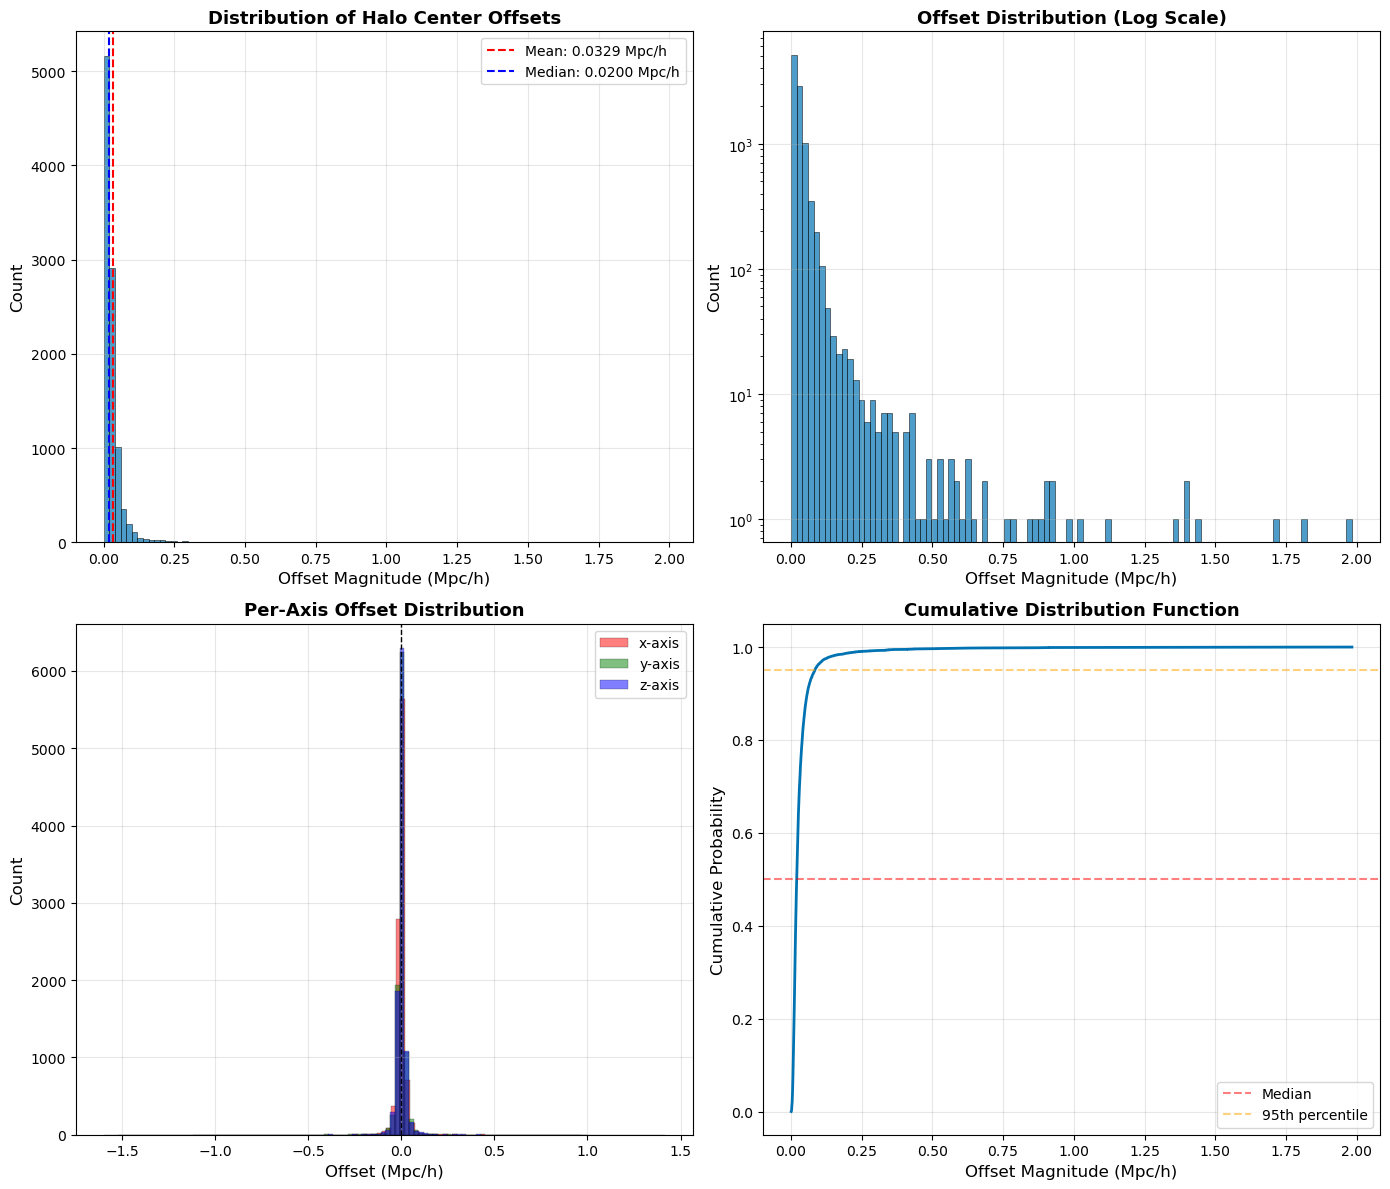

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Offset magnitude distribution
ax = axes[0, 0]
ax.hist(df['offset_mag'], bins=100, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(df['offset_mag'].mean(), color='red', linestyle='--', label=f'Mean: {df["offset_mag"].mean():.4f} Mpc/h')
ax.axvline(df['offset_mag'].median(), color='blue', linestyle='--', label=f'Median: {df["offset_mag"].median():.4f} Mpc/h')
ax.set_xlabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Halo Center Offsets', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Log-scale offset distribution
ax = axes[0, 1]
ax.hist(df['offset_mag'], bins=100, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Offset Distribution (Log Scale)', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(alpha=0.3)

# 3. Per-axis offset distributions
ax = axes[1, 0]
for axis, color in zip(['x', 'y', 'z'], ['red', 'green', 'blue']):
    col = f'offset_{axis}'
    ax.hist(df[col], bins=100, alpha=0.5, label=f'{axis}-axis', color=color, edgecolor='black', linewidth=0.3)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Per-Axis Offset Distribution', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. CDF of offsets
ax = axes[1, 1]
sorted_offsets = np.sort(df['offset_mag'])
cdf = np.arange(1, len(sorted_offsets) + 1) / len(sorted_offsets)
ax.plot(sorted_offsets, cdf, linewidth=2)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Median')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95th percentile')
ax.set_xlabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Distribution Function', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Offset vs Halo Properties

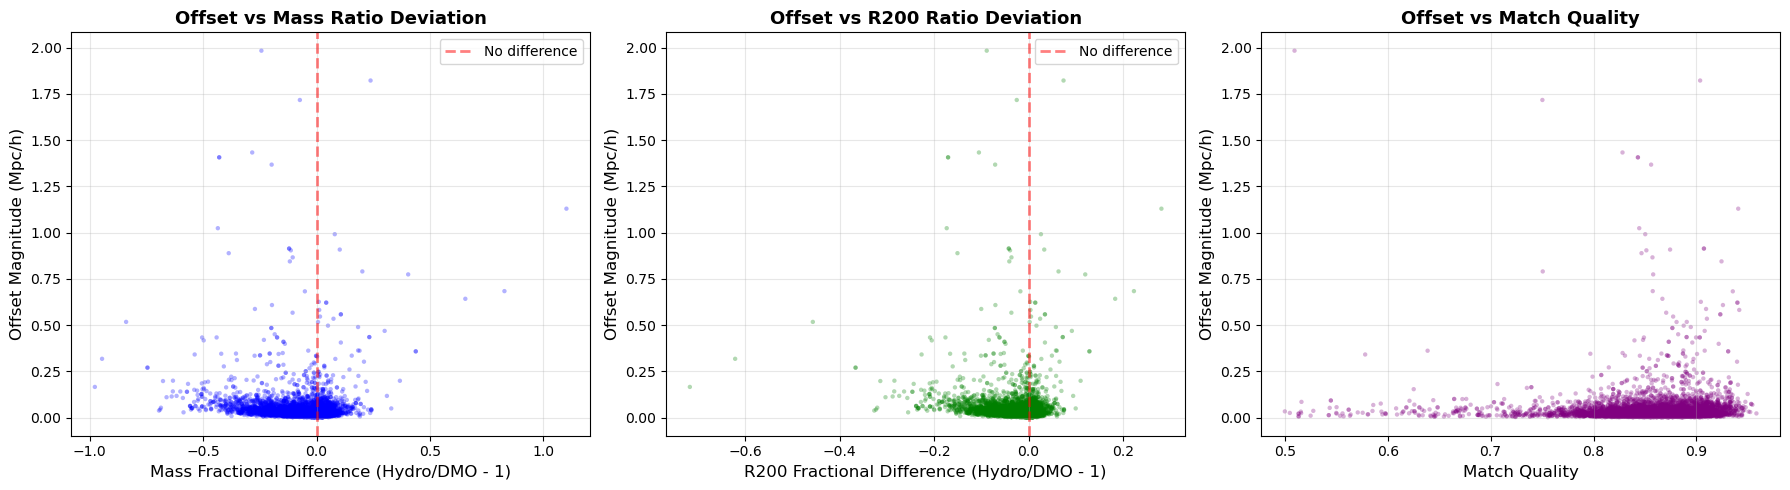

In [78]:
# Calculate normalized offset
df['offset_norm'] = df['offset_mag'] / df['dmo_r200']

# Calculate fractional differences (hydro/dmo - 1)
df['mass_frac_diff'] = df['hydro_mass'] / df['dmo_mass'] - 1.0
df['r200_frac_diff'] = df['hydro_r200'] / df['dmo_r200'] - 1.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Offset vs mass fractional difference
ax = axes[0]
ax.scatter(df['mass_frac_diff'], df['offset_mag'], alpha=0.3, s=10, c='blue', edgecolors='none')
ax.axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='No difference')
ax.set_xlabel('Mass Fractional Difference (Hydro/DMO - 1)', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset vs Mass Ratio Deviation', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Offset vs R200 fractional difference
ax = axes[1]
ax.scatter(df['r200_frac_diff'], df['offset_mag'], alpha=0.3, s=10, c='green', edgecolors='none')
ax.axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='No difference')
ax.set_xlabel('R200 Fractional Difference (Hydro/DMO - 1)', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset vs R200 Ratio Deviation', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Match quality vs offset (if available)
ax = axes[2]
if not df['match_quality'].isna().all():
    ax.scatter(df['match_quality'], df['offset_mag'], alpha=0.3, s=10, c='purple', edgecolors='none')
    ax.set_xlabel('Match Quality', fontsize=12)
    ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
    ax.set_title('Offset vs Match Quality', fontsize=13, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'Match quality\nnot available', ha='center', va='center', fontsize=14)
    ax.set_title('Offset vs Match Quality', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 3D Spatial Distribution of Offset Vectors

Offset vectors are computed as: **DMO position - Hydro position**

This shows the displacement needed to go from hydro halo centers to DMO halo centers.

In [86]:
# Verify offset calculation: DMO - Hydro (with PBC)
print("=== Offset Vector Calculation ===")
print("Offset = DMO center - Hydro center (with periodic boundary conditions)")
print(f"\nSample offsets (first 5 halos):")
for i in range(min(5, len(df))):
    print(f"  Halo {i}: offset = ({df.iloc[i]['offset_x']:.4f}, "
          f"{df.iloc[i]['offset_y']:.4f}, {df.iloc[i]['offset_z']:.4f}) Mpc/h")
    print(f"            |offset| = {df.iloc[i]['offset_mag']:.4f} Mpc/h")

print(f"\n✓ Using {len(df)} offset vectors for visualization")

=== Offset Vector Calculation ===
Offset = DMO center - Hydro center (with periodic boundary conditions)

Sample offsets (first 5 halos):
  Halo 0: offset = (-0.0018, 0.0032, 0.0024) Mpc/h
            |offset| = 0.0044 Mpc/h
  Halo 1: offset = (0.0036, 0.0012, 0.0221) Mpc/h
            |offset| = 0.0225 Mpc/h
  Halo 2: offset = (-0.0103, 0.0219, -0.0100) Mpc/h
            |offset| = 0.0262 Mpc/h
  Halo 3: offset = (-0.0175, 0.0034, -0.0076) Mpc/h
            |offset| = 0.0194 Mpc/h
  Halo 4: offset = (0.0355, -0.0300, -0.0214) Mpc/h
            |offset| = 0.0512 Mpc/h

✓ Using 10000 offset vectors for visualization


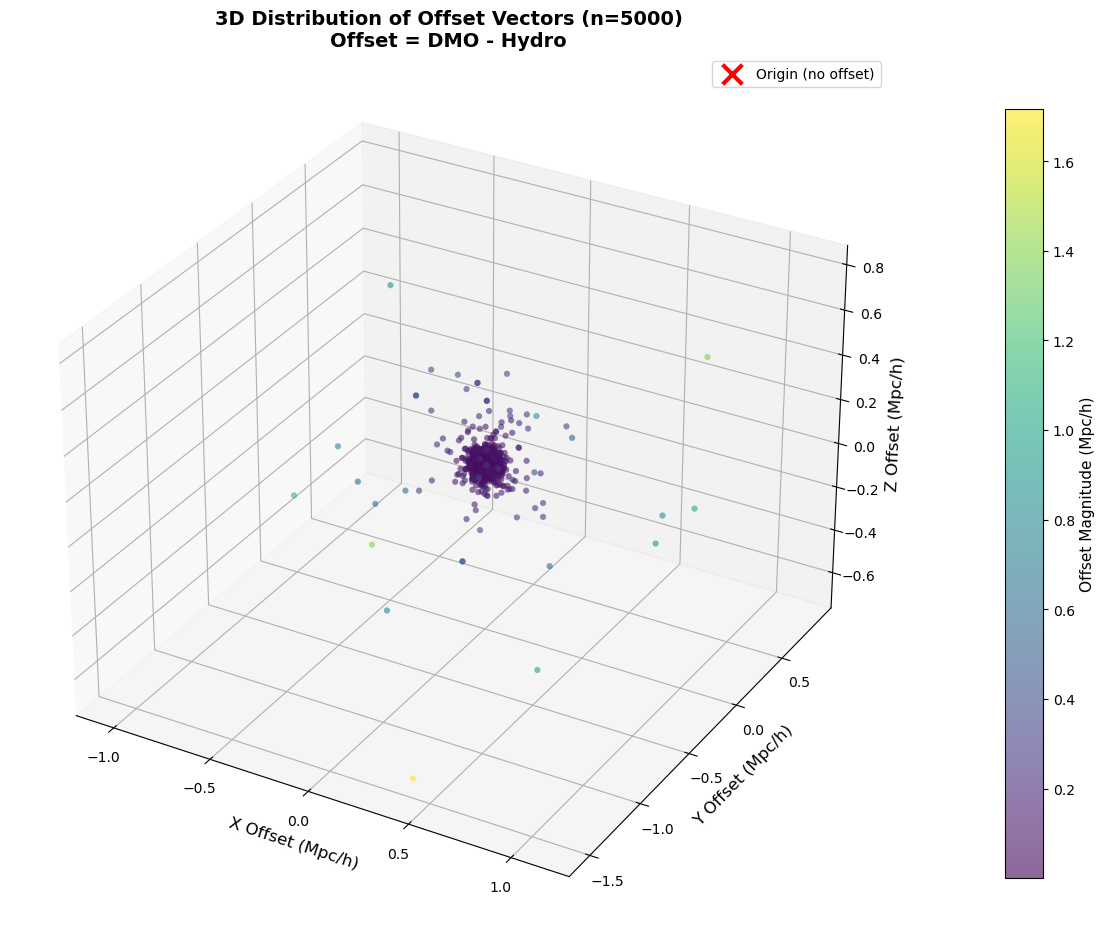


✓ Plotted 5000 offset vectors in 3D
  Red cross marks zero offset (perfect alignment)


In [87]:
# 3D scatter plot of offset vectors
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample for visualization (too many points can be cluttered)
n_plot = min(5000, len(df))
plot_indices = np.random.choice(len(df), n_plot, replace=False)

# Color by offset magnitude
scatter = ax.scatter(df.iloc[plot_indices]['offset_x'], 
                     df.iloc[plot_indices]['offset_y'], 
                     df.iloc[plot_indices]['offset_z'],
                     c=df.iloc[plot_indices]['offset_mag'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=20,
                     edgecolors='none')

# Add origin marker
ax.scatter([0], [0], [0], color='red', s=200, marker='x', linewidths=3, label='Origin (no offset)')

ax.set_xlabel('X Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Y Offset (Mpc/h)', fontsize=12)
ax.set_zlabel('Z Offset (Mpc/h)', fontsize=12)
ax.set_title(f'3D Distribution of Offset Vectors (n={n_plot})\nOffset = DMO - Hydro', 
             fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Offset Magnitude (Mpc/h)', fontsize=11)

ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {n_plot} offset vectors in 3D")
print(f"  Red cross marks zero offset (perfect alignment)")

### 2D Projections (Heatmaps)

Projecting the 3D offset distribution onto each plane:

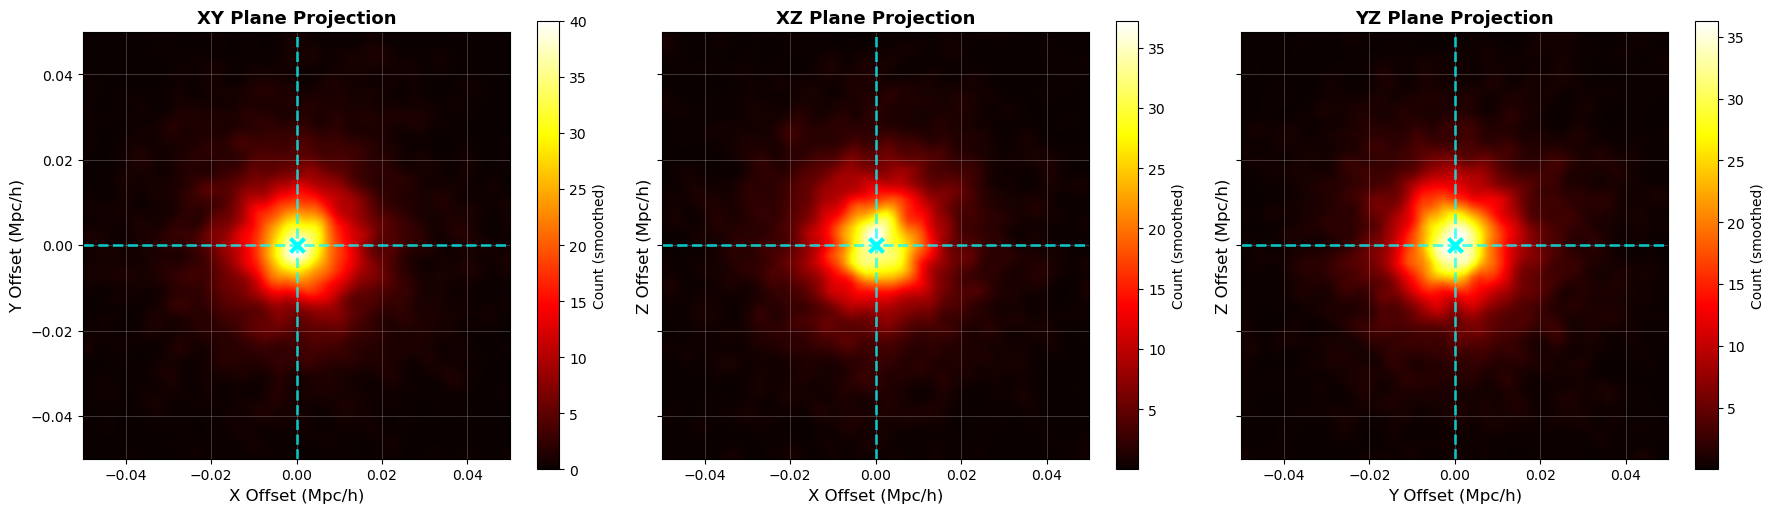


✓ Heatmaps show density of offset vectors projected onto each plane
  Display range: -0.05 to 0.05 Mpc/h
  Cyan crosshairs mark zero offset
  Brighter colors = higher concentration of offsets


In [92]:
from scipy.ndimage import gaussian_filter

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Set consistent range for all plots
offset_range = [-0.05, 0.05]

# XY plane
ax = axes[0]
H, xedges, yedges = np.histogram2d(df['offset_x'], df['offset_y'], 
                                    bins=60, range=[offset_range, offset_range])
H_smooth = gaussian_filter(H.T, sigma=1.0)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
im = ax.imshow(H_smooth, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               origin='lower', cmap='hot', aspect='equal', interpolation='bilinear')
ax.axhline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.axvline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.scatter([0], [0], color='cyan', s=100, marker='x', linewidths=3, zorder=5)
ax.set_xlabel('X Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Y Offset (Mpc/h)', fontsize=12)
ax.set_title('XY Plane Projection', fontsize=13, fontweight='bold')
ax.set_xlim(offset_range)
ax.set_ylim(offset_range)
plt.colorbar(im, ax=ax, label='Count (smoothed)')
ax.grid(alpha=0.3, color='white', linewidth=0.5)

# XZ plane
ax = axes[1]
H, xedges, yedges = np.histogram2d(df['offset_x'], df['offset_z'], 
                                    bins=60, range=[offset_range, offset_range])
H_smooth = gaussian_filter(H.T, sigma=1.0)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
im = ax.imshow(H_smooth, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               origin='lower', cmap='hot', aspect='equal', interpolation='bilinear')
ax.axhline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.axvline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.scatter([0], [0], color='cyan', s=100, marker='x', linewidths=3, zorder=5)
ax.set_xlabel('X Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Z Offset (Mpc/h)', fontsize=12)
ax.set_title('XZ Plane Projection', fontsize=13, fontweight='bold')
ax.set_xlim(offset_range)
ax.set_ylim(offset_range)
plt.colorbar(im, ax=ax, label='Count (smoothed)')
ax.grid(alpha=0.3, color='white', linewidth=0.5)

# YZ plane
ax = axes[2]
H, xedges, yedges = np.histogram2d(df['offset_y'], df['offset_z'], 
                                    bins=60, range=[offset_range, offset_range])
H_smooth = gaussian_filter(H.T, sigma=1.0)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
im = ax.imshow(H_smooth, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               origin='lower', cmap='hot', aspect='equal', interpolation='bilinear')
ax.axhline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.axvline(0, color='cyan', linestyle='--', alpha=0.7, linewidth=2)
ax.scatter([0], [0], color='cyan', s=100, marker='x', linewidths=3, zorder=5)
ax.set_xlabel('Y Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Z Offset (Mpc/h)', fontsize=12)
ax.set_title('YZ Plane Projection', fontsize=13, fontweight='bold')
ax.set_xlim(offset_range)
ax.set_ylim(offset_range)
plt.colorbar(im, ax=ax, label='Count (smoothed)')
ax.grid(alpha=0.3, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n✓ Heatmaps show density of offset vectors projected onto each plane")
print(f"  Display range: {offset_range[0]} to {offset_range[1]} Mpc/h")
print("  Cyan crosshairs mark zero offset")
print("  Brighter colors = higher concentration of offsets")

## 6. Mass Binned Analysis


Offset statistics by mass bin:
                                  mass_bin offset_mag                      \
                                                 mean    median       std   
0  (10001262313472.02, 24434499611869.527]   0.031070  0.018705  0.068446   
1  (24434499611869.527, 59696941502895.48]   0.033381  0.020517  0.066585   
2   (59696941502895.48, 145848078798756.8]   0.036993  0.024608  0.057031   
3  (145848078798756.8, 356327502779293.06]   0.052956  0.032152  0.081326   
4  (356327502779293.06, 870558531059713.8]   0.064411  0.041714  0.096725   

        offset_norm                          dmo_mass  dmo_r200  
  count        mean    median       std          mean      mean  
0  6177    0.078463  0.047230  0.178059  1.526889e+13  0.400555  
1  2602    0.062267  0.038204  0.125127  3.671499e+13  0.536570  
2   953    0.051781  0.034114  0.080338  8.782739e+13  0.718068  
3   233    0.054558  0.034058  0.079106  2.095344e+14  0.959934  
4    34    0.050643  0.028952  0

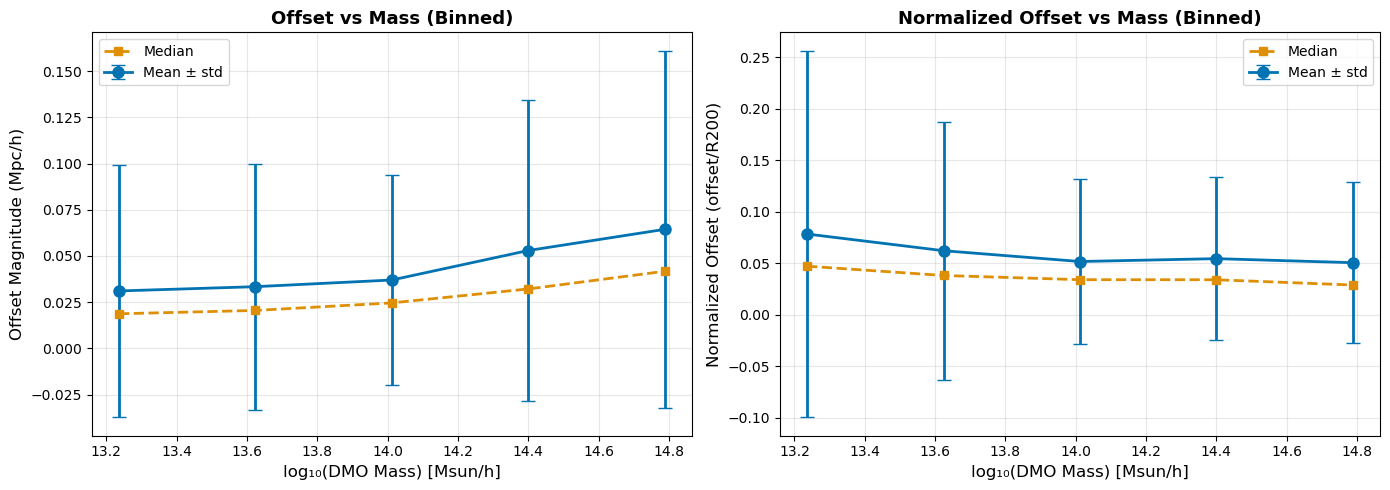

In [93]:
# Define mass bins
mass_bins = np.logspace(np.log10(df['dmo_mass'].min()), np.log10(df['dmo_mass'].max()), 6)
df['mass_bin'] = pd.cut(df['dmo_mass'], bins=mass_bins)

# Compute statistics per bin
bin_stats = df.groupby('mass_bin', observed=True).agg({
    'offset_mag': ['mean', 'median', 'std', 'count'],
    'offset_norm': ['mean', 'median', 'std'],
    'dmo_mass': 'mean',
    'dmo_r200': 'mean',
}).reset_index()

print("\nOffset statistics by mass bin:")
print(bin_stats)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute offset vs mass
ax = axes[0]
bin_centers = np.array([interval.mid for interval in bin_stats['mass_bin']])
ax.errorbar(np.log10(bin_centers), 
            bin_stats[('offset_mag', 'mean')],
            yerr=bin_stats[('offset_mag', 'std')],
            marker='o', markersize=8, capsize=5, linewidth=2, label='Mean ± std')
ax.plot(np.log10(bin_centers), bin_stats[('offset_mag', 'median')], 
        marker='s', markersize=6, linestyle='--', linewidth=2, label='Median')
ax.set_xlabel('log₁₀(DMO Mass) [Msun/h]', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset vs Mass (Binned)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Normalized offset vs mass
ax = axes[1]
ax.errorbar(np.log10(bin_centers), 
            bin_stats[('offset_norm', 'mean')],
            yerr=bin_stats[('offset_norm', 'std')],
            marker='o', markersize=8, capsize=5, linewidth=2, label='Mean ± std')
ax.plot(np.log10(bin_centers), bin_stats[('offset_norm', 'median')], 
        marker='s', markersize=6, linestyle='--', linewidth=2, label='Median')
ax.set_xlabel('log₁₀(DMO Mass) [Msun/h]', fontsize=12)
ax.set_ylabel('Normalized Offset (offset/R200)', fontsize=12)
ax.set_title('Normalized Offset vs Mass (Binned)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Extreme Cases: Largest Offsets

## 6.5. Offset vs Cosmological/Astrophysical Parameters

The training data includes CAMELS parameters. Let's examine correlations between halo center offsets and key parameters:
- **Omega_m**: Matter density parameter
- **sigma_8**: Amplitude of matter fluctuations
- **A_SN1, A_SN2**: Supernova feedback strength
- **A_AGN1**: AGN feedback strength

In [94]:
# Define key parameters to analyze
# Focus on the most physically important ones
key_params = [
    'Omega_m',      # Matter density
    'sigma_8',      # Amplitude of fluctuations
    'A_SN1',        # Supernova feedback energy
    'A_AGN1',       # AGN feedback energy
    'A_SN2',        # Supernova wind speed
    'Omega_b',      # Baryon density
    'h',            # Hubble parameter
]

# Check which are available
available_params = [p for p in key_params if p in df.columns]

print(f"Analyzing {len(available_params)} key parameters:")
print(f"\nParameter statistics:")
for param in available_params:
    print(f"  {param:20s}: mean={df[param].mean():8.4f}, std={df[param].std():8.4f}, "
          f"range=[{df[param].min():8.4f}, {df[param].max():8.4f}]")

Analyzing 7 key parameters:

Parameter statistics:
  Omega_m             : mean=  0.3477, std=  0.0952, range=[  0.1001,   0.4991]
  sigma_8             : mean=  0.8134, std=  0.1138, range=[  0.6001,   0.9998]
  A_SN1               : mean=  4.8946, std=  3.7168, range=[  0.9073,  14.3230]
  A_AGN1              : mean=  1.3620, std=  1.0258, range=[  0.2510,   3.9957]
  A_SN2               : mean=  8.1225, std=  3.1718, range=[  3.7168,  14.7890]
  Omega_b             : mean=  0.0482, std=  0.0115, range=[  0.0290,   0.0689]
  h                   : mean=  0.6776, std=  0.1146, range=[  0.4711,   0.8708]


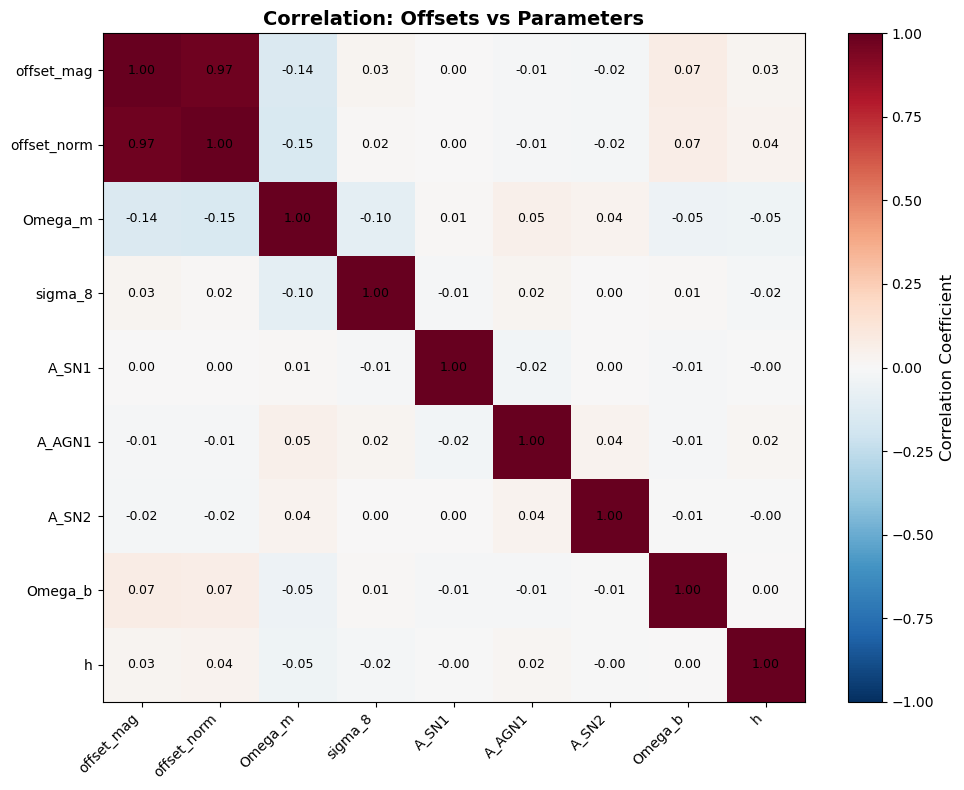


=== Significant Correlations (|r| > 0.1) ===
Omega_m:
  vs offset_mag:  r = -0.144
  vs offset_norm: r = -0.150


In [95]:
# Correlation matrix between offsets and key parameters
if available_params:
    corr_data = df[['offset_mag', 'offset_norm'] + available_params].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_data, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', fontsize=12)
    
    # Set ticks and labels
    ax.set_xticks(range(len(corr_data.columns)))
    ax.set_yticks(range(len(corr_data.columns)))
    ax.set_xticklabels(corr_data.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_data.columns)
    
    # Add correlation values as text
    for i in range(len(corr_data)):
        for j in range(len(corr_data)):
            text = ax.text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    ax.set_title('Correlation: Offsets vs Parameters', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print significant correlations
    print("\n=== Significant Correlations (|r| > 0.1) ===")
    for param in available_params:
        r_mag = corr_data.loc['offset_mag', param]
        r_norm = corr_data.loc['offset_norm', param]
        if abs(r_mag) > 0.1 or abs(r_norm) > 0.1:
            print(f"{param}:")
            print(f"  vs offset_mag:  r = {r_mag:+.3f}")
            print(f"  vs offset_norm: r = {r_norm:+.3f}")
else:
    print("No parameters available for correlation analysis")

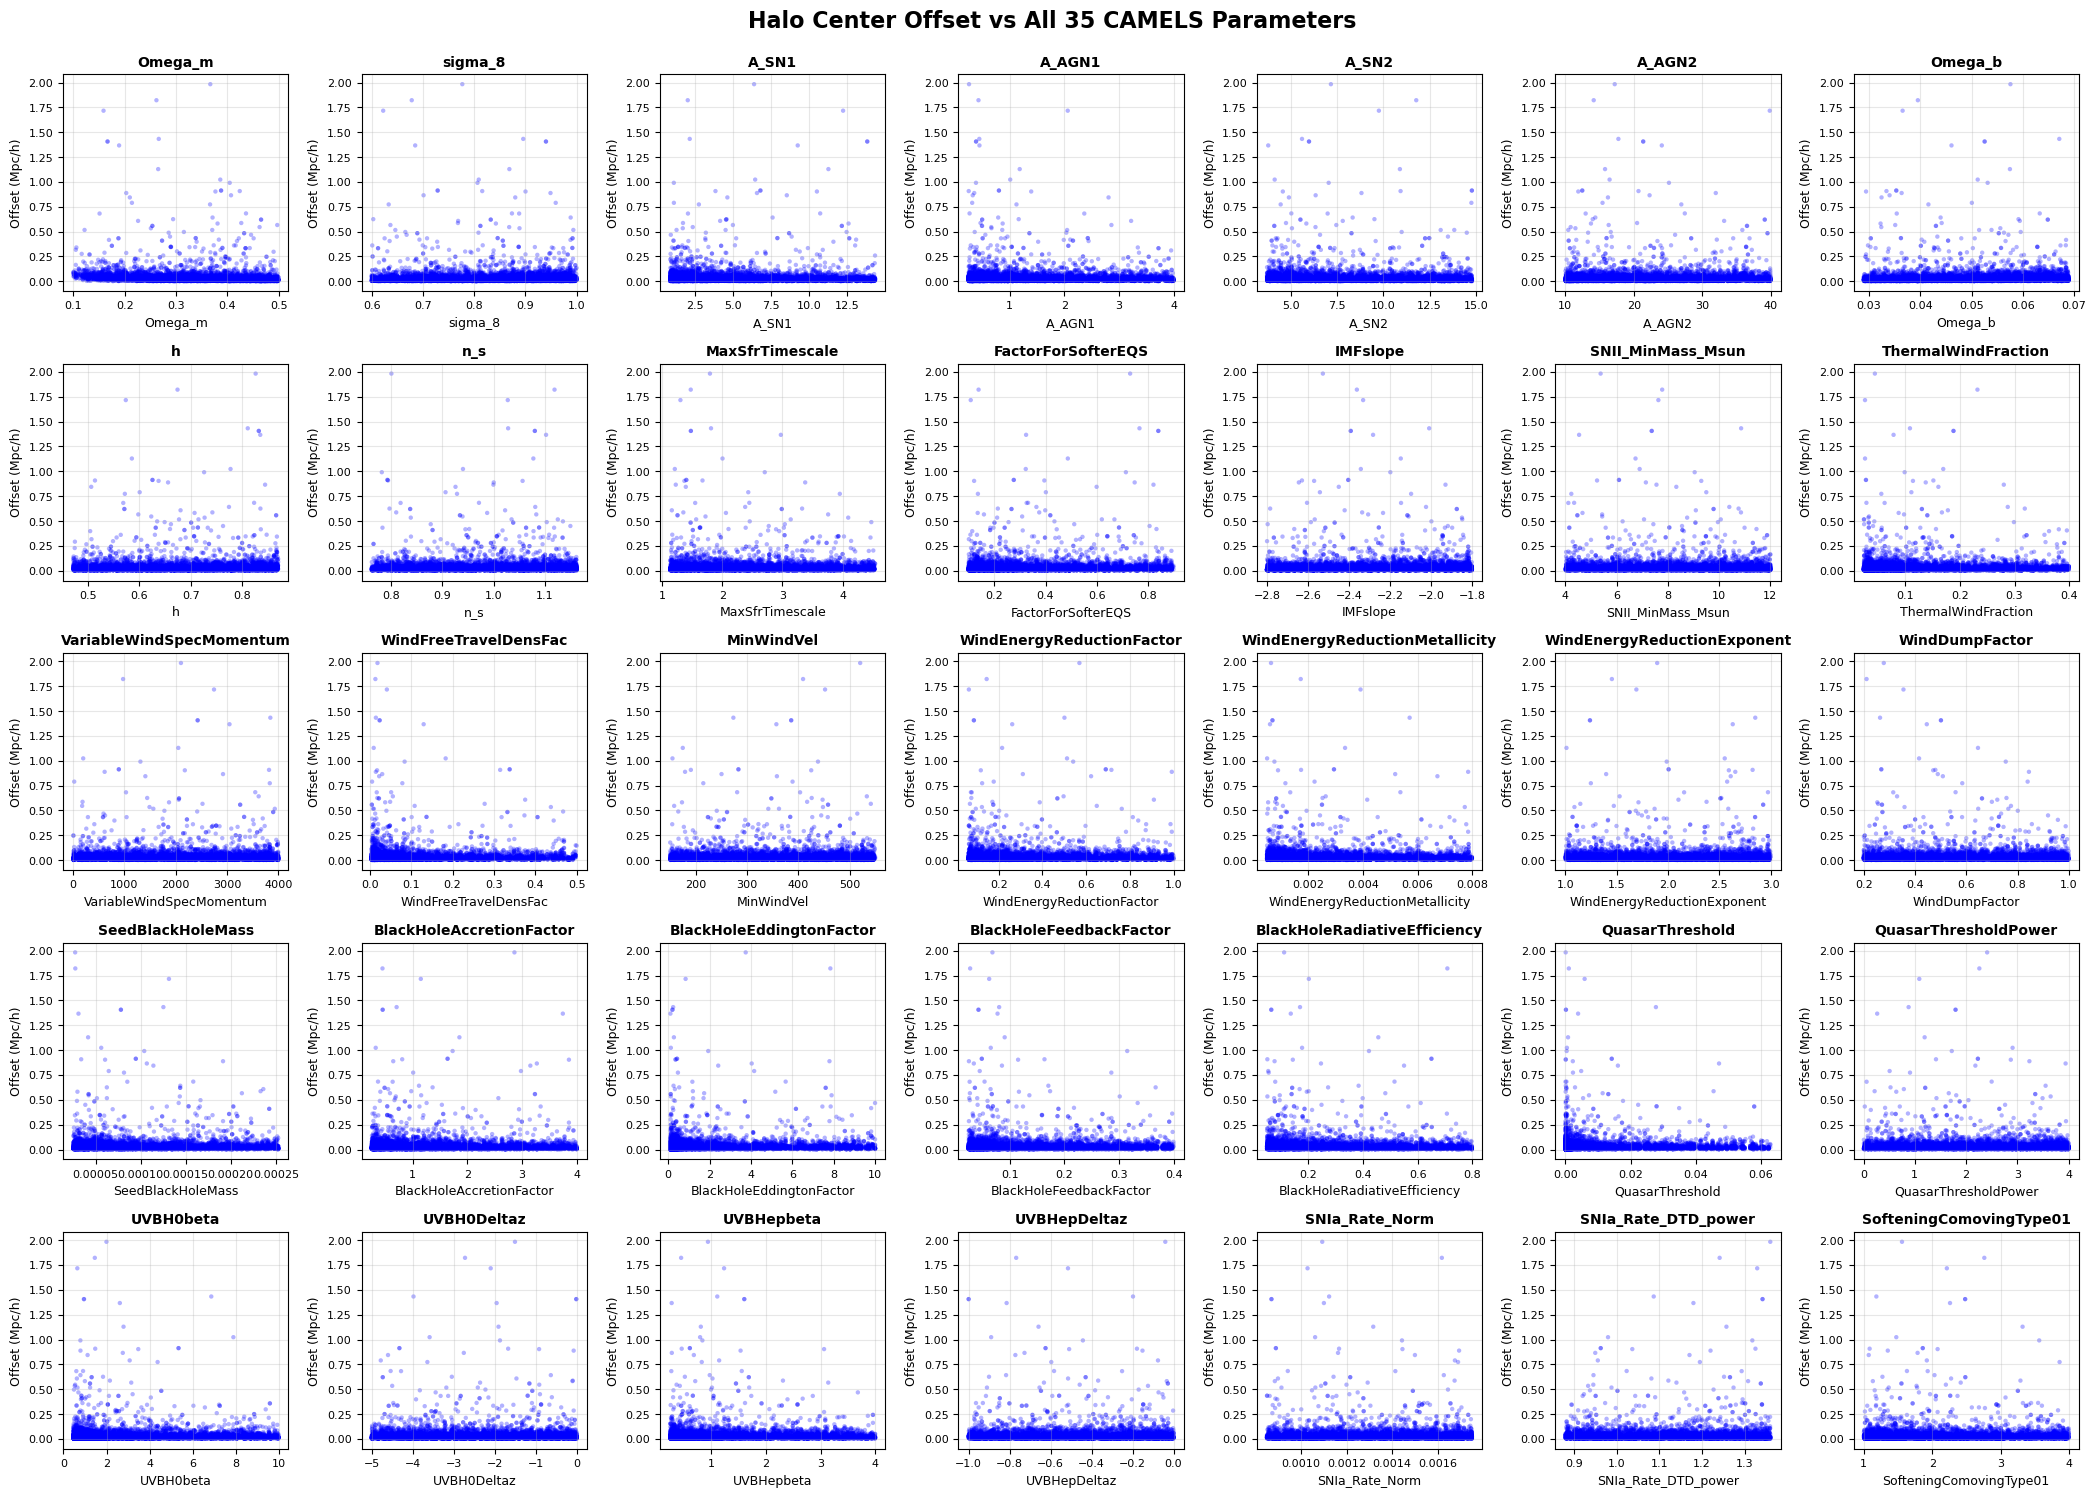

Plotted 35 parameters


In [96]:
# Scatter plots: Offset vs ALL 35 parameters
# 5 rows x 7 columns = 35 subplots
all_params = [p for p in PARAM_NAMES if p in df.columns]

if all_params:
    n_rows = 5
    n_cols = 7
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 15))
    
    for idx, param in enumerate(all_params):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Scatter plot with transparency
        ax.scatter(df[param], df['offset_mag'], alpha=0.3, s=10, c='blue', edgecolors='none')
        ax.set_xlabel(param, fontsize=9)
        ax.set_ylabel('Offset (Mpc/h)', fontsize=9)
        ax.set_title(f'{param}', fontsize=10, fontweight='bold')
        ax.tick_params(labelsize=8)
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(all_params), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Halo Center Offset vs All 35 CAMELS Parameters', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {len(all_params)} parameters")
else:
    print("No parameters available for scatter plots")

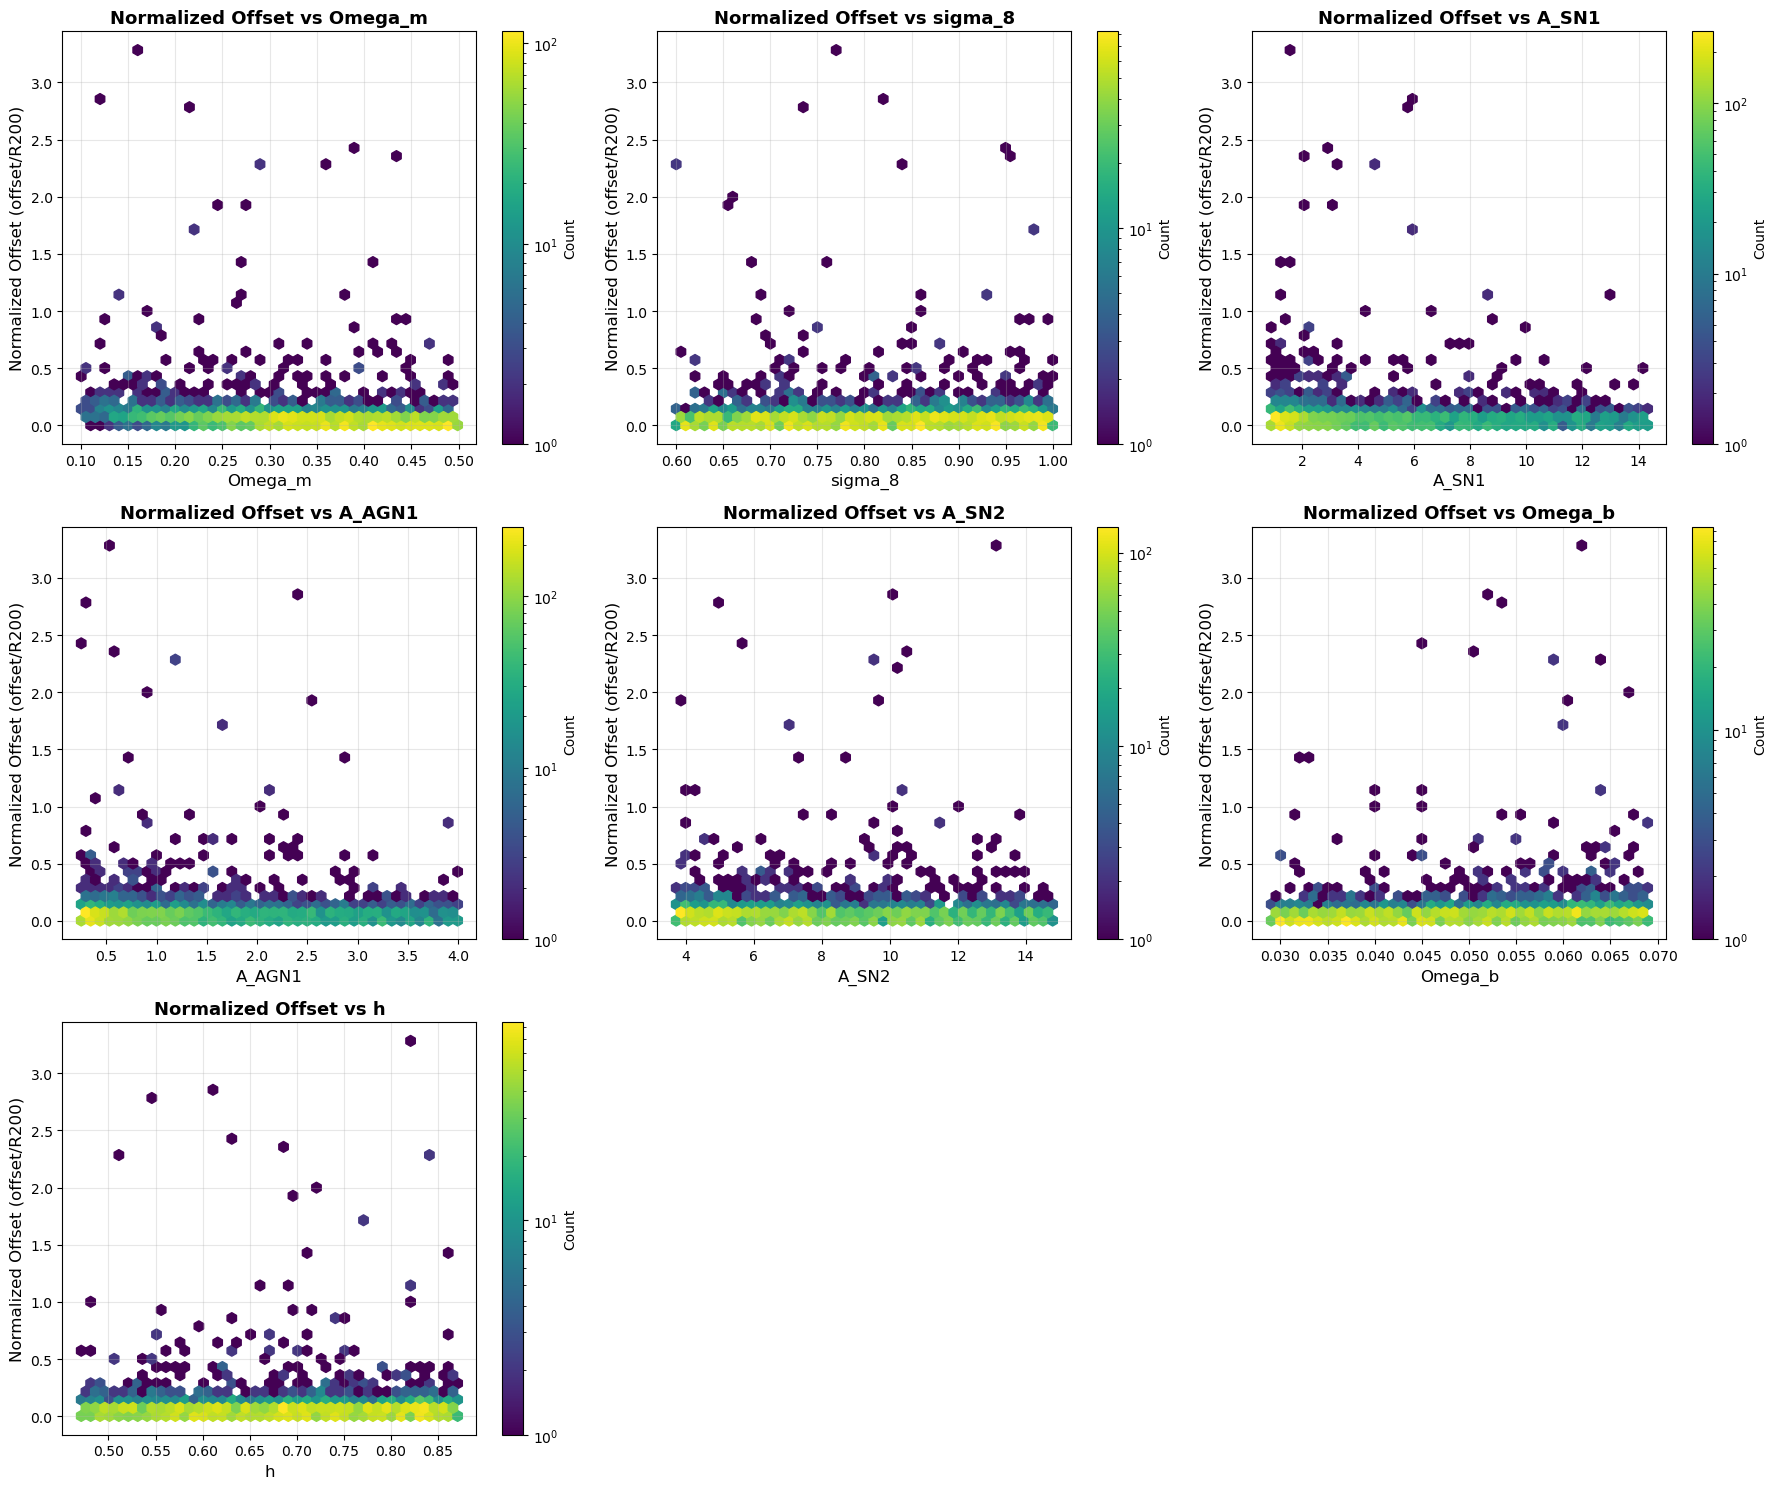

In [ ]:
# Normalized offset vs ALL 35 parameters (mass-independent view)
# 5 rows x 7 columns = 35 subplots
if all_params:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 15))
    
    for idx, param in enumerate(all_params):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Scatter plot with transparency
        ax.scatter(df[param], df['offset_norm'], alpha=0.3, s=10, c='green', edgecolors='none')
        ax.set_xlabel(param, fontsize=9)
        ax.set_ylabel('Offset/R200', fontsize=9)
        ax.set_title(f'{param}', fontsize=10, fontweight='bold')
        ax.tick_params(labelsize=8)
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(all_params), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Normalized Halo Center Offset vs All 35 CAMELS Parameters', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted normalized offsets for {len(all_params)} parameters")
else:
    print("No parameters available for normalized offset plots")


=== Top 20 Halos with Largest Offsets ===
      offset_mag  offset_norm      dmo_mass    hydro_mass  dmo_r200  hydro_r200  match_quality
9522    1.983382     4.638473  1.817438e+13  1.375501e+13  0.427594    0.389670       0.509405
7961    1.821998     3.562082  3.110887e+13  3.851204e+13  0.511498    0.549235       0.903634
1366    1.716790     4.864971  1.021498e+13  9.463178e+12  0.352888    0.344006       0.750320
8647    1.432993     3.592486  1.475265e+13  1.056849e+13  0.398886    0.356917       0.828188
1505    1.406693     3.825851  1.155379e+13  6.595096e+12  0.367681    0.305003       0.843147
2284    1.406693     3.825851  1.155379e+13  6.595096e+12  0.367681    0.305003       0.843147
9666    1.367314     3.722007  1.152479e+13  9.243082e+12  0.367359    0.341315       0.855989
4257    1.129181     1.571224  8.628663e+13  1.813221e+14  0.718663    0.920530       0.940662
9384    1.023647     2.809499  1.124424e+13  6.351189e+12  0.364352    0.301186       0.844442
4108   

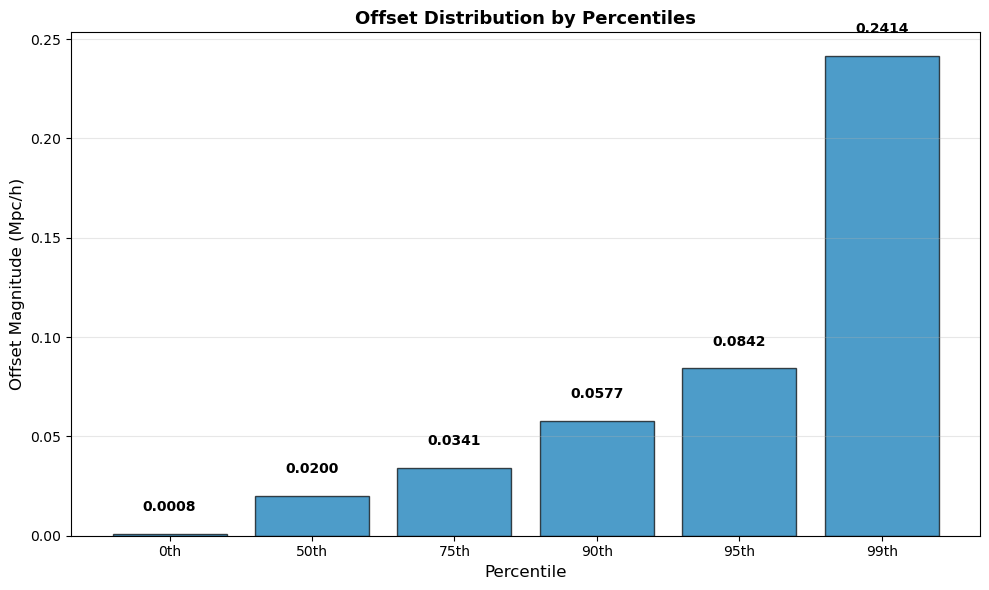

In [97]:
# Find halos with largest offsets
top_offsets = df.nlargest(20, 'offset_mag')

print("\n=== Top 20 Halos with Largest Offsets ===")
print(top_offsets[['offset_mag', 'offset_norm', 'dmo_mass', 'hydro_mass', 
                    'dmo_r200', 'hydro_r200', 'match_quality']].to_string())

# Box plot by percentiles
fig, ax = plt.subplots(figsize=(10, 6))

percentiles = [0, 50, 75, 90, 95, 99]
offset_percentiles = [df['offset_mag'].quantile(p/100) for p in percentiles]

ax.bar(range(len(percentiles)), offset_percentiles, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(percentiles)))
ax.set_xticklabels([f'{p}th' for p in percentiles])
ax.set_xlabel('Percentile', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset Distribution by Percentiles', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Add values on bars
for i, val in enumerate(offset_percentiles):
    ax.text(i, val + 0.01, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Summary and Implications

Key findings from this analysis:

1. **Typical offset magnitude**: Check mean/median values above
2. **Mass dependence**: Examine correlation between halo mass and offset
3. **Isotropy**: Check if offsets are isotropic or show preferred directions
4. **Normalized offsets**: Compare offset/R200 across mass scales

**Implications for training:**
- Offsets indicate systematic differences in halo identification between DMO and hydro
- Large offsets may introduce noise in the training data
- Consider filtering halos with large normalized offsets (offset/R200 > threshold)
- Bijective matching ensures 1-1 correspondence but doesn't guarantee spatial alignment

## 9. Satellite Halo Offsets (Peak Detection Analysis)

We can detect satellite halos by finding local maxima (peaks) in the density maps. This approach:
1. Finds peaks in the DMO map (dark matter subhalos)
2. Finds peaks in the hydro DM map (baryonic-influenced subhalos)
3. Matches nearby peaks between DMO and hydro
4. Measures the offset between matched peaks

This gives us insight into how baryonic physics affects satellite positions within halos.

In [98]:
# Load a sample of cutouts to analyze satellite peaks
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist

def find_peaks_2d(field, min_distance=3, threshold_percentile=90):
    """
    Find local maxima in a 2D field.
    
    Parameters:
    -----------
    field : 2D array
        Density field
    min_distance : int
        Minimum distance between peaks (in pixels)
    threshold_percentile : float
        Only consider peaks above this percentile
    
    Returns:
    --------
    peaks : array of shape (n_peaks, 2)
        Coordinates of peaks [y, x]
    """
    # Apply maximum filter to find local maxima
    local_max = maximum_filter(field, size=min_distance) == field
    
    # Threshold to avoid noise
    threshold = np.percentile(field, threshold_percentile)
    local_max = local_max & (field > threshold)
    
    # Get coordinates
    peaks = np.column_stack(np.where(local_max))
    
    return peaks

def match_peaks(peaks1, peaks2, max_distance=10):
    """
    Match peaks between two sets based on proximity.
    
    Parameters:
    -----------
    peaks1 : array (n1, 2)
        First set of peaks
    peaks2 : array (n2, 2)
        Second set of peaks
    max_distance : float
        Maximum distance for matching (in pixels)
    
    Returns:
    --------
    matches : list of tuples
        (idx1, idx2, distance) for matched peaks
    """
    if len(peaks1) == 0 or len(peaks2) == 0:
        return []
    
    # Compute pairwise distances
    distances = cdist(peaks1, peaks2)
    
    matches = []
    used_peaks2 = set()
    
    # Greedy matching: assign each peak1 to nearest peak2
    for i in range(len(peaks1)):
        min_idx = np.argmin(distances[i])
        min_dist = distances[i, min_idx]
        
        if min_dist < max_distance and min_idx not in used_peaks2:
            matches.append((i, min_idx, min_dist))
            used_peaks2.add(min_idx)
    
    return matches

print("Peak detection functions defined!")

Peak detection functions defined!


In [99]:
# Load cutouts and detect satellite peaks
N_CUTOUTS = 100  # Sample size
satellite_data = []

print(f"Loading {N_CUTOUTS} cutouts for satellite analysis...")

for fpath in tqdm(sample_files[:N_CUTOUTS], desc="Analyzing satellites"):
    try:
        data = np.load(fpath)
        
        # Load 2D projections
        dmo_condition = data['condition']  # DMO field (128x128)
        hydro_target = data['target']  # Hydro fields [DM_hydro, gas, stars]
        
        # Use DM channels (first channel)
        dmo_map = dmo_condition if dmo_condition.ndim == 2 else dmo_condition[0]
        hydro_dm_map = hydro_target[0]  # DM_hydro channel
        
        # Find peaks in both maps
        dmo_peaks = find_peaks_2d(dmo_map, min_distance=5, threshold_percentile=85)
        hydro_peaks = find_peaks_2d(hydro_dm_map, min_distance=5, threshold_percentile=85)
        
        # Match peaks
        matches = match_peaks(dmo_peaks, hydro_peaks, max_distance=15)
        
        # Convert pixel offsets to physical units (assuming 6.25 Mpc/h cutout, 128 pixels)
        pixel_to_mpc = 6.25 / 128  # ~0.049 Mpc/h per pixel
        
        for dmo_idx, hydro_idx, pixel_dist in matches:
            dmo_pos = dmo_peaks[dmo_idx]
            hydro_pos = hydro_peaks[hydro_idx]
            
            offset_pixels = hydro_pos - dmo_pos  # [dy, dx]
            offset_mpc = offset_pixels * pixel_to_mpc
            offset_mag = np.linalg.norm(offset_mpc)
            
            # Get peak intensities
            dmo_intensity = dmo_map[dmo_pos[0], dmo_pos[1]]
            hydro_intensity = hydro_dm_map[hydro_pos[0], hydro_pos[1]]
            
            satellite_data.append({
                'offset_x': offset_mpc[1],  # x is second coordinate
                'offset_y': offset_mpc[0],  # y is first coordinate
                'offset_mag': offset_mag,
                'pixel_offset': pixel_dist,
                'dmo_intensity': dmo_intensity,
                'hydro_intensity': hydro_intensity,
                'dmo_pos_x': dmo_pos[1],
                'dmo_pos_y': dmo_pos[0],
                'hydro_pos_x': hydro_pos[1],
                'hydro_pos_y': hydro_pos[0],
                'file': fpath,
            })
            
    except Exception as e:
        print(f"Error processing {fpath}: {e}")
        continue

# Convert to DataFrame
sat_df = pd.DataFrame(satellite_data)
print(f"\nFound {len(sat_df)} matched satellite peaks!")
print(f"\nSatellite offset statistics:")
print(f"  Mean: {sat_df['offset_mag'].mean():.4f} Mpc/h")
print(f"  Median: {sat_df['offset_mag'].median():.4f} Mpc/h")
print(f"  Std: {sat_df['offset_mag'].std():.4f} Mpc/h")
print(f"  Max: {sat_df['offset_mag'].max():.4f} Mpc/h")

Loading 100 cutouts for satellite analysis...


Analyzing satellites: 100%|██████████| 100/100 [00:00<00:00, 122.74it/s]



Found 15846 matched satellite peaks!

Satellite offset statistics:
  Mean: 0.0611 Mpc/h
  Median: 0.0488 Mpc/h
  Std: 0.0776 Mpc/h
  Max: 0.7259 Mpc/h


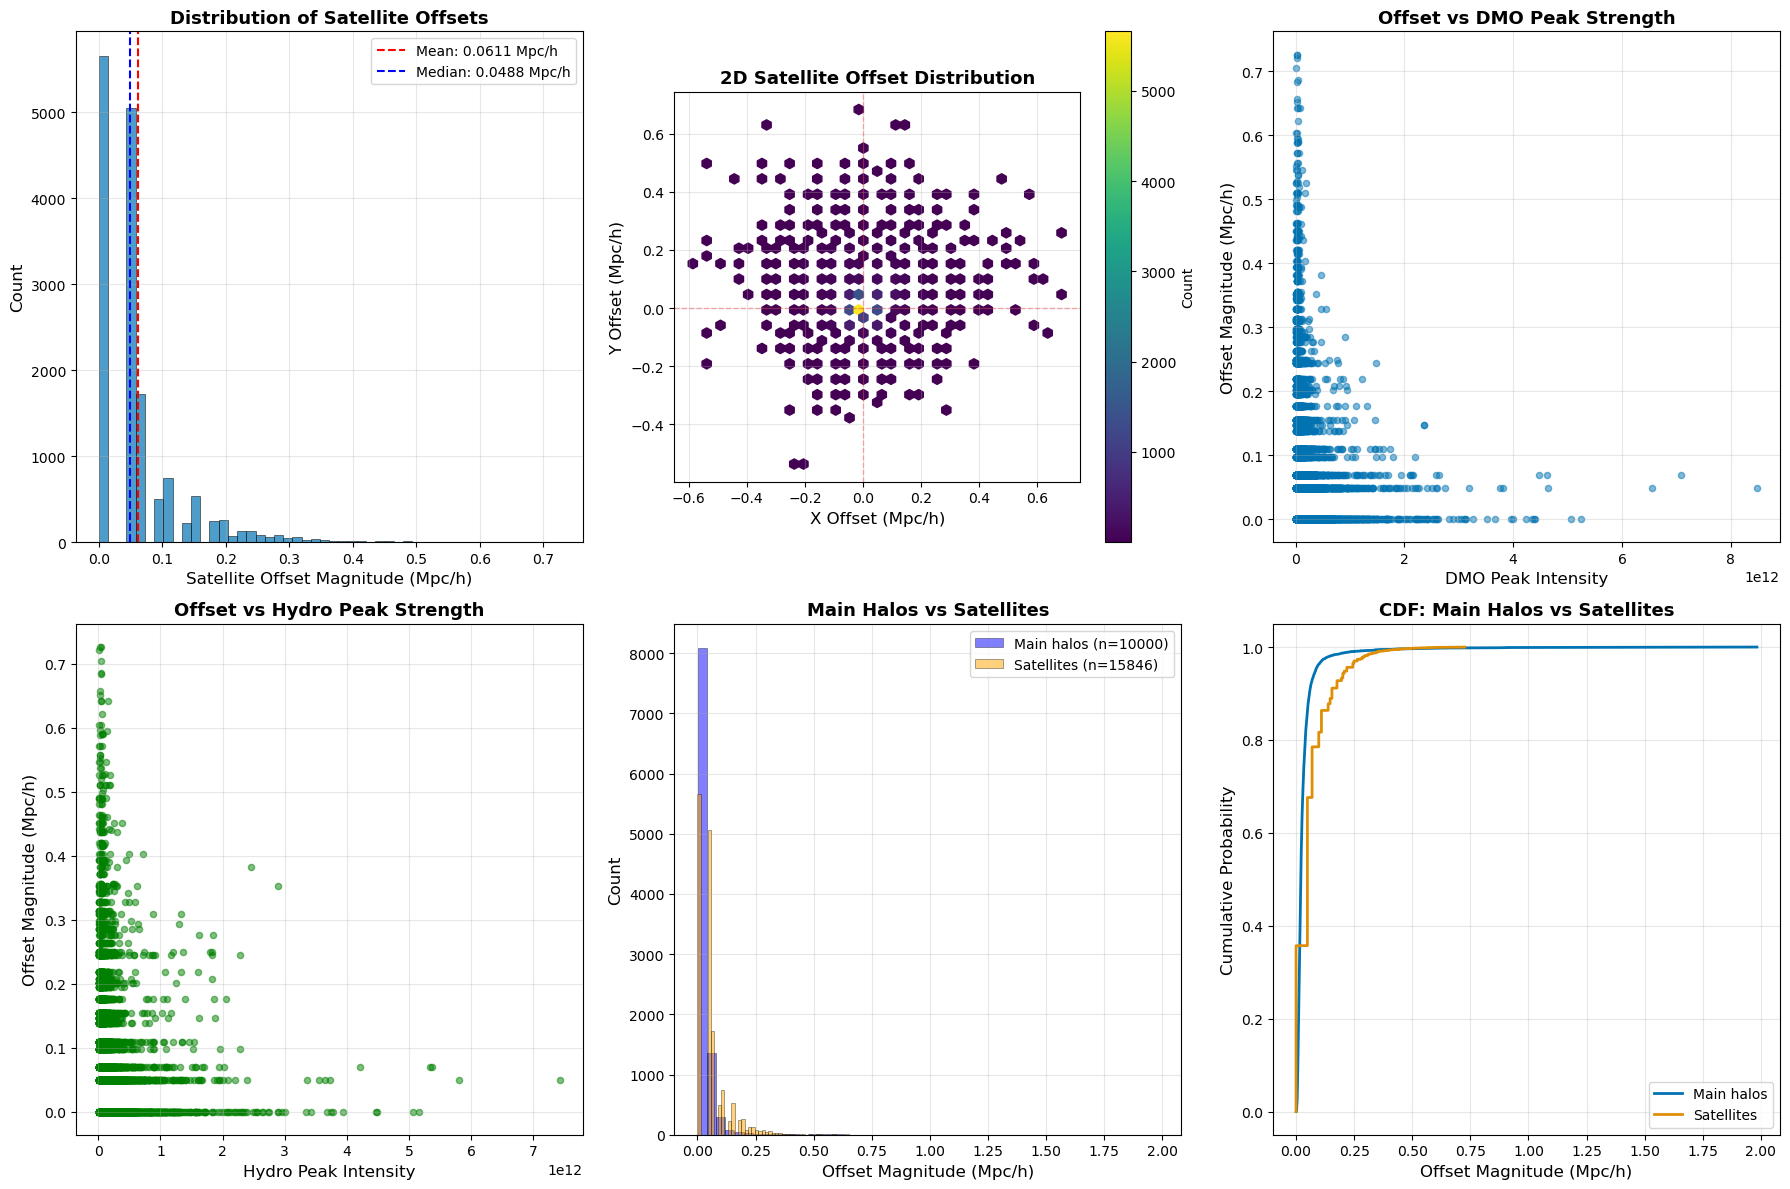


=== Comparison: Main Halos vs Satellites ===
Main halos:
  Mean offset: 0.0329 Mpc/h
  Median offset: 0.0200 Mpc/h

Satellites:
  Mean offset: 0.0611 Mpc/h
  Median offset: 0.0488 Mpc/h

Ratio (satellite/main): 1.86x


In [100]:
# Visualize satellite offsets
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Satellite offset magnitude distribution
ax = axes[0, 0]
ax.hist(sat_df['offset_mag'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(sat_df['offset_mag'].mean(), color='red', linestyle='--', 
           label=f'Mean: {sat_df["offset_mag"].mean():.4f} Mpc/h')
ax.axvline(sat_df['offset_mag'].median(), color='blue', linestyle='--', 
           label=f'Median: {sat_df["offset_mag"].median():.4f} Mpc/h')
ax.set_xlabel('Satellite Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Satellite Offsets', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. 2D offset distribution
ax = axes[0, 1]
h = ax.hexbin(sat_df['offset_x'], sat_df['offset_y'], gridsize=40, cmap='viridis', mincnt=1)
ax.axhline(0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('X Offset (Mpc/h)', fontsize=12)
ax.set_ylabel('Y Offset (Mpc/h)', fontsize=12)
ax.set_title('2D Satellite Offset Distribution', fontsize=13, fontweight='bold')
ax.set_aspect('equal')
plt.colorbar(h, ax=ax, label='Count')
ax.grid(alpha=0.3)

# 3. Offset vs DMO peak intensity
ax = axes[0, 2]
ax.scatter(sat_df['dmo_intensity'], sat_df['offset_mag'], alpha=0.5, s=20)
ax.set_xlabel('DMO Peak Intensity', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset vs DMO Peak Strength', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# 4. Offset vs Hydro peak intensity
ax = axes[1, 0]
ax.scatter(sat_df['hydro_intensity'], sat_df['offset_mag'], alpha=0.5, s=20, color='green')
ax.set_xlabel('Hydro Peak Intensity', fontsize=12)
ax.set_ylabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_title('Offset vs Hydro Peak Strength', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# 5. Comparison: Main halo vs Satellites
ax = axes[1, 1]
ax.hist(df['offset_mag'], bins=50, alpha=0.5, label=f'Main halos (n={len(df)})', 
        color='blue', edgecolor='black', linewidth=0.5)
ax.hist(sat_df['offset_mag'], bins=50, alpha=0.5, label=f'Satellites (n={len(sat_df)})', 
        color='orange', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Main Halos vs Satellites', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. CDF comparison
ax = axes[1, 2]
sorted_main = np.sort(df['offset_mag'])
cdf_main = np.arange(1, len(sorted_main) + 1) / len(sorted_main)
sorted_sat = np.sort(sat_df['offset_mag'])
cdf_sat = np.arange(1, len(sorted_sat) + 1) / len(sorted_sat)
ax.plot(sorted_main, cdf_main, linewidth=2, label='Main halos')
ax.plot(sorted_sat, cdf_sat, linewidth=2, label='Satellites')
ax.set_xlabel('Offset Magnitude (Mpc/h)', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('CDF: Main Halos vs Satellites', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\n=== Comparison: Main Halos vs Satellites ===")
print(f"Main halos:")
print(f"  Mean offset: {df['offset_mag'].mean():.4f} Mpc/h")
print(f"  Median offset: {df['offset_mag'].median():.4f} Mpc/h")
print(f"\nSatellites:")
print(f"  Mean offset: {sat_df['offset_mag'].mean():.4f} Mpc/h")
print(f"  Median offset: {sat_df['offset_mag'].median():.4f} Mpc/h")
print(f"\nRatio (satellite/main): {sat_df['offset_mag'].mean() / df['offset_mag'].mean():.2f}x")

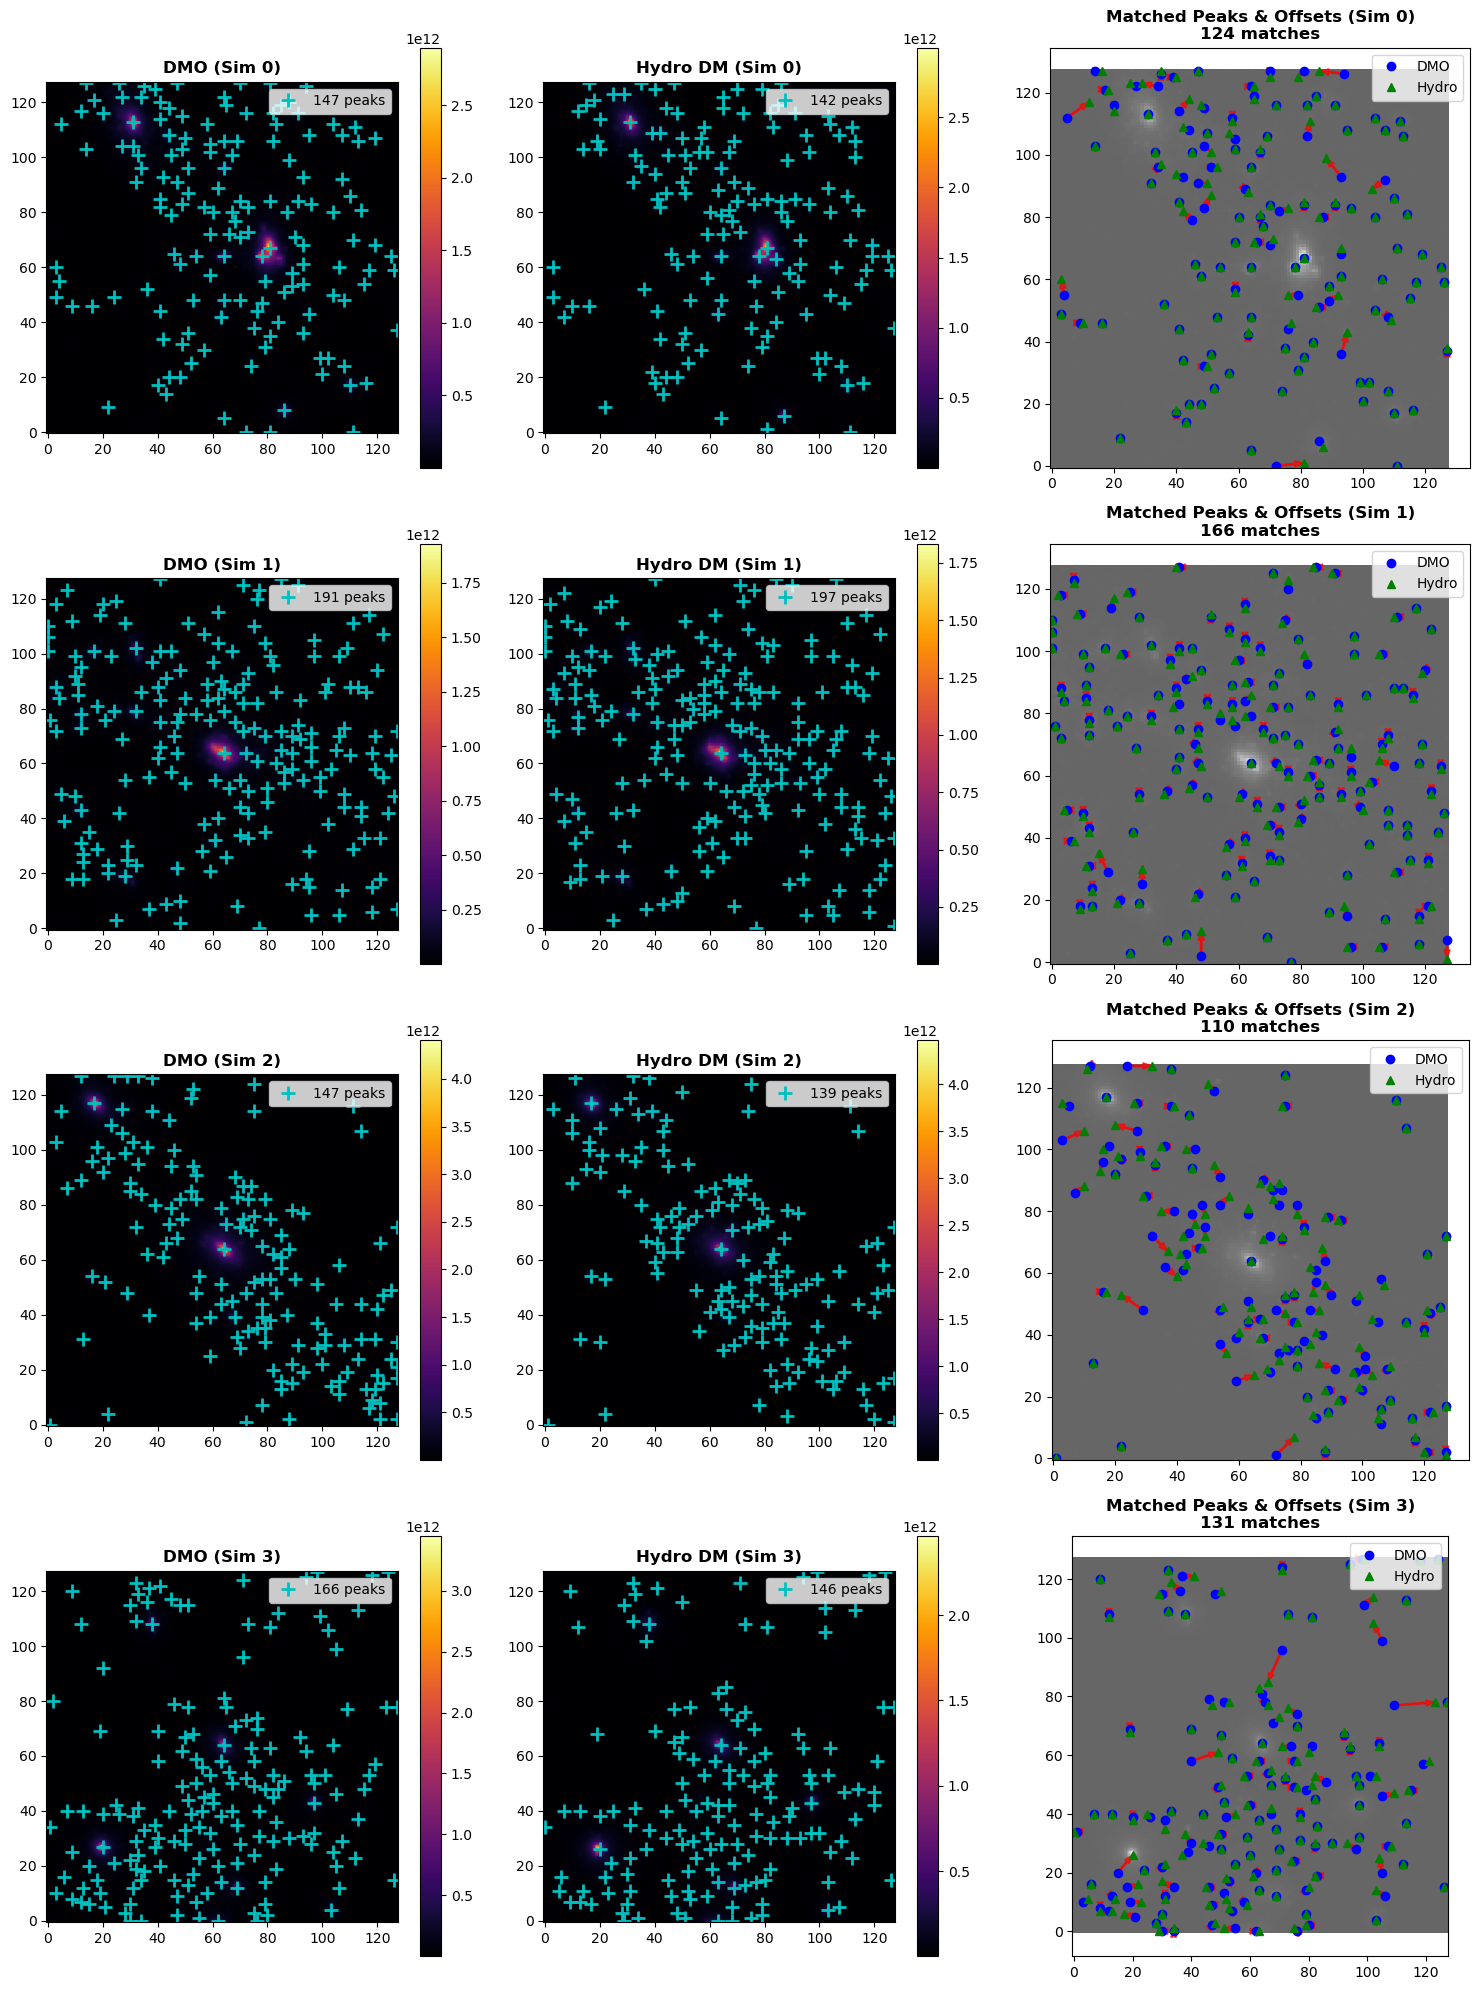


✓ Visualized 4 example cutouts with detected satellites
  Cyan '+': Detected peaks
  Red arrows: DMO → Hydro offset vectors
  Blue circles: DMO peak positions
  Green triangles: Hydro peak positions


In [101]:
# Visualize example cutouts with detected peaks
# Show a few examples to validate the peak detection
n_examples = 4
example_files = sample_files[:n_examples]

fig, axes = plt.subplots(n_examples, 3, figsize=(15, 5*n_examples))

for idx, fpath in enumerate(example_files):
    data = np.load(fpath)
    
    dmo_condition = data['condition']
    hydro_target = data['target']
    
    dmo_map = dmo_condition if dmo_condition.ndim == 2 else dmo_condition[0]
    hydro_dm_map = hydro_target[0]
    
    # Find peaks
    dmo_peaks = find_peaks_2d(dmo_map, min_distance=5, threshold_percentile=85)
    hydro_peaks = find_peaks_2d(hydro_dm_map, min_distance=5, threshold_percentile=85)
    matches = match_peaks(dmo_peaks, hydro_peaks, max_distance=15)
    
    # Plot DMO
    ax = axes[idx, 0]
    im = ax.imshow(dmo_map, cmap='inferno', origin='lower')
    ax.plot(dmo_peaks[:, 1], dmo_peaks[:, 0], 'c+', markersize=10, markeredgewidth=2, label=f'{len(dmo_peaks)} peaks')
    ax.set_title(f'DMO (Sim {idx})', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    plt.colorbar(im, ax=ax)
    
    # Plot Hydro DM
    ax = axes[idx, 1]
    im = ax.imshow(hydro_dm_map, cmap='inferno', origin='lower')
    ax.plot(hydro_peaks[:, 1], hydro_peaks[:, 0], 'c+', markersize=10, markeredgewidth=2, label=f'{len(hydro_peaks)} peaks')
    ax.set_title(f'Hydro DM (Sim {idx})', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    plt.colorbar(im, ax=ax)
    
    # Plot matched peaks with offset vectors
    ax = axes[idx, 2]
    im = ax.imshow(dmo_map, cmap='gray', origin='lower', alpha=0.6)
    
    # Draw arrows from DMO to Hydro peaks
    for dmo_idx, hydro_idx, dist in matches:
        dmo_pos = dmo_peaks[dmo_idx]
        hydro_pos = hydro_peaks[hydro_idx]
        ax.arrow(dmo_pos[1], dmo_pos[0], 
                hydro_pos[1] - dmo_pos[1], hydro_pos[0] - dmo_pos[0],
                color='red', alpha=0.7, width=0.5, head_width=2, length_includes_head=True)
        ax.plot(dmo_pos[1], dmo_pos[0], 'bo', markersize=6, label='DMO' if dmo_idx == 0 else '')
        ax.plot(hydro_pos[1], hydro_pos[0], 'g^', markersize=6, label='Hydro' if dmo_idx == 0 else '')
    
    ax.set_title(f'Matched Peaks & Offsets (Sim {idx})\n{len(matches)} matches', 
                fontsize=12, fontweight='bold')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {n_examples} example cutouts with detected satellites")
print(f"  Cyan '+': Detected peaks")
print(f"  Red arrows: DMO → Hydro offset vectors")
print(f"  Blue circles: DMO peak positions")
print(f"  Green triangles: Hydro peak positions")

In [102]:
# Save summary statistics
summary = {
    'n_halos': len(df),
    'offset_mean': df['offset_mag'].mean(),
    'offset_median': df['offset_mag'].median(),
    'offset_std': df['offset_mag'].std(),
    'offset_p95': df['offset_mag'].quantile(0.95),
    'offset_max': df['offset_mag'].max(),
    'offset_norm_mean': df['offset_norm'].mean(),
    'offset_norm_median': df['offset_norm'].median(),
    'mass_ratio_mean': (df['hydro_mass'] / df['dmo_mass']).mean(),
    'r200_ratio_mean': (df['hydro_r200'] / df['dmo_r200']).mean(),
}

print("\n=== Summary Statistics ===")
for key, val in summary.items():
    print(f"{key}: {val:.6f}")

# Recommendation
print("\n=== Recommendation ===")
if df['offset_norm'].median() < 0.1:
    print("✓ Median normalized offset < 0.1 R200: Good alignment between DMO and hydro halos")
elif df['offset_norm'].median() < 0.2:
    print("⚠ Median normalized offset 0.1-0.2 R200: Moderate misalignment - acceptable but consider filtering")
else:
    print("✗ Median normalized offset > 0.2 R200: Significant misalignment - recommend filtering")

if df['offset_mag'].quantile(0.95) > 0.5:
    print(f"⚠ 95th percentile offset > 0.5 Mpc/h: Consider filtering outliers")


=== Summary Statistics ===
n_halos: 10000.000000
offset_mean: 0.032856
offset_median: 0.020027
offset_std: 0.067509
offset_p95: 0.084191
offset_max: 1.983382
offset_norm_mean: 0.071049
offset_norm_median: 0.042871
mass_ratio_mean: 0.957770
r200_ratio_mean: 0.984292

=== Recommendation ===
✓ Median normalized offset < 0.1 R200: Good alignment between DMO and hydro halos
